In [1]:
import torch
import torch.nn.functional as F

### Adding Context

Previously in bigrams we considered the probability of a character given the previous character (hence the bi in bigram). Now we'd like to add more context, Lets consider the probabilty of the next character given three previous characters.

In [2]:
names = open("names.txt", "r").read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(names)

32033

In [4]:
### Build the vocab ###

#find all characters in our dataset
vocab = sorted(list(set(''.join(names))))
vocab.insert(0, ".")

#create vocab mappings
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for idx, char in enumerate(vocab)}

In [5]:
context_len = 3
X, Y = [], []

for name in names[:5]:
    #initalise context with "." characters (index 0)
    context = [0] * context_len
    
    print(name)
    for char in name + ".": # add end character to the name
        y = char_to_idx[char]
        X.append(context)
        Y.append(y)
        print(f'{"".join(idx_to_char[idx] for idx in context)} ---> {idx_to_char[y]} | {context} ---> {y}')

        #shift the context (like a rolling window)
        context = context[1:] + [y]
    
    print(end='\n')

#store as tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e | [0, 0, 0] ---> 5
..e ---> m | [0, 0, 5] ---> 13
.em ---> m | [0, 5, 13] ---> 13
emm ---> a | [5, 13, 13] ---> 1
mma ---> . | [13, 13, 1] ---> 0

olivia
... ---> o | [0, 0, 0] ---> 15
..o ---> l | [0, 0, 15] ---> 12
.ol ---> i | [0, 15, 12] ---> 9
oli ---> v | [15, 12, 9] ---> 22
liv ---> i | [12, 9, 22] ---> 9
ivi ---> a | [9, 22, 9] ---> 1
via ---> . | [22, 9, 1] ---> 0

ava
... ---> a | [0, 0, 0] ---> 1
..a ---> v | [0, 0, 1] ---> 22
.av ---> a | [0, 1, 22] ---> 1
ava ---> . | [1, 22, 1] ---> 0

isabella
... ---> i | [0, 0, 0] ---> 9
..i ---> s | [0, 0, 9] ---> 19
.is ---> a | [0, 9, 19] ---> 1
isa ---> b | [9, 19, 1] ---> 2
sab ---> e | [19, 1, 2] ---> 5
abe ---> l | [1, 2, 5] ---> 12
bel ---> l | [2, 5, 12] ---> 12
ell ---> a | [5, 12, 12] ---> 1
lla ---> . | [12, 12, 1] ---> 0

sophia
... ---> s | [0, 0, 0] ---> 19
..s ---> o | [0, 0, 19] ---> 15
.so ---> p | [0, 19, 15] ---> 16
sop ---> h | [19, 15, 16] ---> 8
oph ---> i | [15, 16, 8] ---> 9
phi ---> a | [16, 8,

In [6]:
print(f"{X.shape} with dtype: {X.dtype}")
print(f"{Y.shape} with dtype: {Y.dtype}")

torch.Size([32, 3]) with dtype: torch.int64
torch.Size([32]) with dtype: torch.int64


In [7]:
# create our embedding "table". embedding dimension is 2. we embed each character into a two dimensional space
C = torch.randn((27, 2))

SIDE NOTE: we can think of this "lookup" in the embedding table in two ways.LookupError
 1. using the indexes of the char in the vocab directly (index into the embedding table)
 2. encode the indexes into one-hot encoding (thus multiply the embedding table by the encoded indexes ) 

In [8]:
# 1st row is: ... ---> e | [0, 0, 0] ---> 5

print(f"First way: \nX[0] = {X[0]} gives y[0] = {Y[0]}. Indexing into C[[0, 0, 0]] = \n{C[X[0]]}")

First way: 
X[0] = tensor([0, 0, 0]) gives y[0] = 5. Indexing into C[[0, 0, 0]] = 
tensor([[-0.0719,  1.2916],
        [-0.0719,  1.2916],
        [-0.0719,  1.2916]])


In [9]:
# second way
F.one_hot(X[0], num_classes=27).float() @ C

tensor([[-0.0719,  1.2916],
        [-0.0719,  1.2916],
        [-0.0719,  1.2916]])

In [10]:
C[X[0]].shape
# 3 context chars x 2 embedding dims

torch.Size([3, 2])

In [11]:
C[X[0]].view((6,)) # reshape/view this tensor as a (6,) to feed as input into the 1st hidden layer

tensor([-0.0719,  1.2916, -0.0719,  1.2916, -0.0719,  1.2916])

In [12]:
#-1 means pytorch will work out that dim based on the other dim (i.e. we want 6 columns, tell us how many rows we need)
x1 = C[X].view(-1, 6) # C[X] (batch_shape, input_shape)=(32, 3, 2) where input_shape=(3, 2) [context_dim, emb_dim]

x1.shape #x1 (batch_dim, 6) as we have asked pytorch to view it this way (Concatinate the context dim into one row)

torch.Size([32, 6])

In [13]:
#hiddden layer with tanh activation
w1 = torch.randn((6, 100)) #dim=(input_dim, num_of_neurons)
b1 = torch.randn((100)) #dim=(num_of_neurons) each neuron has one bias
h1 = torch.tanh(x1@w1 + b1) # CHECK BROADCASTING

In [14]:
#BROADCASTING CHECK
# x1@w1 = (32, 100) (batch_dim, input_shape)x(input_shape, num_of_neurons)=(batch_dim, num_of_neurons)
#    b1 = (100) row vector of bias' one bias for each neuron!

#Align to the right
#         (32, 100)
#         (  , 100)

# broadcast b1. the right most matches GOOD. the left most will be matched to i.e. broadcasted to 32 dim
# b1_bcast (32, 100) i.e. b1 row vector copied along the rows 32 times! EXACTLY WHAT WE WANT!


In [15]:
h1.shape # (batch_num, input_shape)x(input_shape, num_of_neurons) = (batch_shape, num_of_neurons)

torch.Size([32, 100])

In [16]:
## Second and final hidden layer
# GOAL: output a prob dist over our vocab where the highest prob will be the prediction for the next character (given our context window)

w2 = torch.randn((100, 27)) #input:(batch_dim, input_shape)=(32, 100) we want output_dim (i.e. number of neurons) to be len(vocab)=27 
b2 = torch.randn((27)) # each neuron has a bias

logits = h1@w2 + b2 #Checked broadcasting earlier, b2 is a row vector, which we want copied for each example in our batch (down the batch dim i.e. the rows)

In [17]:
# softmax activation.
# This converts the 27 dim row rector into a probability dist

its = logits.exp()
prob_dists = its / its.sum(1, keepdim=True) # sum over 1st dimension (len(vocab)) keepdim means we want column vector (each chara to be divided by the sum - copy across the 27 columns!)
prob_dists.shape # (batch_dim, len(vocab))

torch.Size([32, 27])

In [18]:
# We end up with a prob dist over the vocab for each of our 32 examples
# we can pick out the probabilty of the targets Y

# recall Y is the index in our vocab for the next character, so our model should be assigning high prob to that index
# i.e.  ... ---> e | [0, 0, 0] ---> 5 so the 5th index for the first example should have a high prob (after training)

prob_of_targets = prob_dists[torch.arange(0, 32), Y] # Y represents the columns we wanyt to pick out, the index in the vocab. we have 32 examples.
prob_of_targets

tensor([2.1719e-02, 8.5987e-10, 2.8688e-07, 1.0117e-08, 7.0515e-06, 9.5067e-12,
        1.6529e-04, 2.2495e-10, 2.1192e-12, 5.4288e-12, 2.4975e-02, 6.8472e-01,
        3.0829e-06, 1.3437e-07, 2.4738e-09, 1.8249e-07, 2.1146e-09, 5.1132e-05,
        9.6815e-10, 1.0182e-03, 2.9467e-12, 4.3447e-11, 1.1929e-06, 2.7705e-07,
        3.5158e-02, 1.2558e-11, 5.2283e-12, 8.7406e-11, 1.2526e-08, 5.4334e-09,
        1.3700e-07, 1.1685e-02])

so prob of picking 5th index in our vocab is 7.6933e-09. the higher these probabilties the better the model

In [19]:
## measure the loss (ve- average log likelihood)

loss = -prob_of_targets.log().mean() 
loss

tensor(16.2122)

Note: We use the mean log likelihood rather than the sum of the log likelihoods to ensure that batch size (N) is independent from the learning rate. In the mean we divide through by N, removing the infulence of batch size. If we took the sum, then the loss is influenced by the batch_size, which during gradient decent, where we mutliply through by a learning rate, will require different learning rates for different batch_sizes. (unless you data set splits perfectly into an equal number of batches - will cause a problem). Thus the mean is the way!  

In [20]:
## Bring it all together

## Parameters ##
C = torch.randn((27, 2))

w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 

w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 

parameters = [C, w1, b1, w2, b2]

In [21]:
print(f"We have {sum(p.nelement() for p in parameters)} elements")

We have 3481 elements


In [22]:
## to run the backwards pass we need to set requires_grad().
for p in parameters:
    p.requires_grad = True

In [23]:
## forward pass ##

emb = C[X] # (32, 3, 2)
#x1 =  #(32, 6)
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 100)
logits = h1 @ w2 + b2 #(32, 27)
# its = logits.exp()
# prob_dists = its / its.sum(1, keepdim=True)
# prob_of_targets = prob_dists[torch.arange(0, 32), Y]
# loss = -prob_of_targets.log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(19.7916, grad_fn=<NllLossBackward0>)

In [24]:
F.cross_entropy(logits, Y)

tensor(19.7916, grad_fn=<NllLossBackward0>)

the cross entropy loss is the same as the negative log likelihood in the case where there is only one correct char.
all other positions in the cross entopry loss will be zero. 
pytorch will regonise that you are sending in indexes (representing one correct char - rather than say three, and set y_trues all to zero, appart from the index)


benifits of using cross entropy
1. the intermedery steps are usually computed in a fused kernel and so are very effecient (no extra tensors are made, like in our imp)
2. the backwards pass is more efficent since (through analytical mathematics we can derive the exact derivative) and so dont need to work the dervivate out for each of the intermediate steps - like we would if we did our implementation
   (and example of this can be seen in tanh - we know the exact derivative (through analytical methods its (1-t**2))
3. our previous method can not handle large logits (since exp(100) is inf - **This is called overflow**) to solve this, because of the normalisation, we can add/minus any arbitary number. take the number to be the max of the logits and minus. that way we get zero or negative numbers... problem solved (only possible due to normalisation)

In [25]:
## backward pass ##
for p in parameters:
    p.grad = None
loss.backward()

In [26]:
## update the parameters ##
for p in parameters:
    p.data += -0.1 * p.grad

In [27]:
## run another forward pass having updated and see the loss decrease ##
emb = C[X] # (32, 3, 2)
#x1 =  #(32, 6)
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 100)
logits = h1 @ w2 + b2 #(32, 27)
# its = logits.exp()
# prob_dists = its / its.sum(1, keepdim=True)
# prob_of_targets = prob_dists[torch.arange(0, 32), Y]
# loss = -prob_of_targets.log().mean()
loss = F.cross_entropy(logits, Y)
loss.item()

16.394893646240234

#### Bring it all together | 32 data Examples (from the 1st five words)

In [28]:
for p in parameters:
    p.requires_grad = True

In [29]:
iterations = 1000
for _ in range(iterations):
    ## FORWARD PASS ##
    emb = C[X] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y) #softmax is applied internally
    

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    for p in parameters:
        p.data += -0.1 * p.grad
print(f"Final Loss: {loss.item():.3f}")

Final Loss: 0.257


Here we get a very low loss because we are overfitting. we have 32 examples but 3481 parameters. Notice though that we dont get exatly zero, well that because we have inputs that give multiple output values in our training set. so for exampl ... as an input gives e (for the first name emma), a (for the second name ava), and so on, we have multiple names that start with different letters.

#### Bring it all together | ALL data Examples

In [30]:
context_len = 3
X, Y = [], []

for name in names:
    #initalise context with "." characters (index 0)
    context = [0] * context_len
    
    for char in name + ".": # add end character to the name
        y = char_to_idx[char]
        X.append(context)
        Y.append(y)

        #shift the context (like a rolling window)
        context = context[1:] + [y]

#store as tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

In [32]:
print(f"{X.shape} with dtype: {X.dtype}")
print(f"{Y.shape} with dtype: {Y.dtype}")

torch.Size([228146, 3]) with dtype: torch.int64
torch.Size([228146]) with dtype: torch.int64


In [33]:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

In [34]:
iterations = 10
for _ in range(iterations):
    ## FORWARD PASS ##
    emb = C[X] # (228146, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(228146, 6)x(6, 100) gives (228146, 100)
    logits = h1 @ w2 + b2 #(228146, 27)
    loss = F.cross_entropy(logits, Y) #softmax is applied internally
    print(f"Loss: {loss.item():.3f}")

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    for p in parameters:
        p.data += -0.1 * p.grad
print(f"Final Loss: {loss.item():.3f}")

Loss: 16.780
Loss: 15.217
Loss: 14.000
Loss: 13.222
Loss: 12.526
Loss: 11.879
Loss: 11.273
Loss: 10.700
Loss: 10.161
Loss: 9.663
Final Loss: 9.663


Much Slower! because we are training over the whole dataset (228146 examples) in each iteration, which is too much work. Lets split into mini batches.

It is better to move in the approximate gradient direction and take more steps than it is to get the exact gradient and take fewer steps!

We approximate the true value of the gradient by calculating the gradient for our mini batch (its a batch not all of the data points hence why its an approximation!!).

In [35]:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

In [36]:
iterations = 1000
mini_batch_size = 32

for _ in range(iterations):

    # construct mini batch (randomly select 32 examples with replacement)
    # select 32 integers (which represent the indexes of our training set)
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X[ix]] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    for p in parameters:
        p.data += -0.1 * p.grad
print(f"Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: {loss.item():.3f}")

Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: 2.686


In [37]:
# Run the forward pass on the whole data to get the full model loss

## FORWARD PASS ##
emb = C[X] # <-- evaluating all of X
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h1 @ w2 + b2
loss = F.cross_entropy(logits, Y) #<-- All of Y
print(f"Model Loss (after iterating over mini batches) {loss.item():.3f}")

Model Loss (after iterating over mini batches) 2.675


### A way to explore the learning rate in the Upgrade step

In [38]:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

iterations = 1000 
mini_batch_size = 32

## Construct Learning rates ##
lr_linear =  torch.linspace(0.001, 1, iterations)
lr_exp_trans = torch.linspace(-3, 0, iterations)
lr_exp = 10**lr_exp_trans # -3 because 10**-3 = 0.001 and 0 because 10**0 = 1

# keep track of the learning rates used; so we can plot
lr_idx = []
lr_loss = []


for i in range(iterations):#reversed(range(iterations)):

   
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X[ix]] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    lr = lr_exp[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    #track the learning rates and the loss
    lr_idx.append(lr)
    lr_loss.append(loss.item())
print(f"Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: {loss.item():.3f}")

Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: 8.492


Text(0.5, 1.0, 'Starts small and gets large | jumps are exponential (so loads for small values, few for large) | time dir -->')

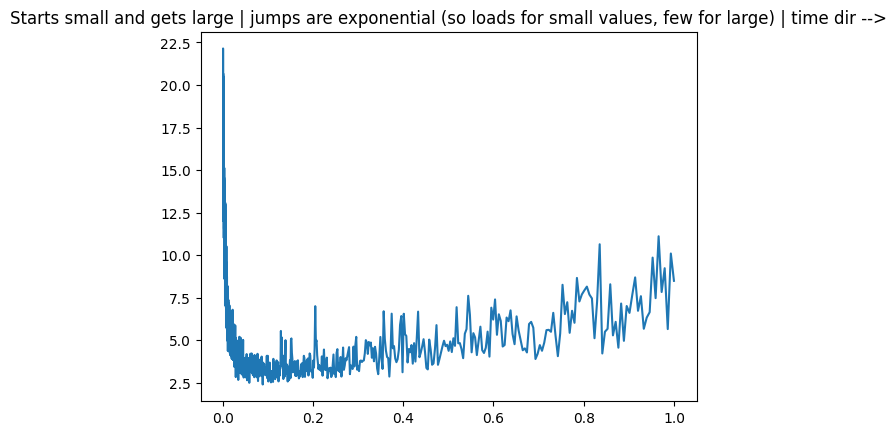

In [39]:
import matplotlib.pyplot as plt

plt.plot(lr_idx, lr_loss)
plt.title("Starts small and gets large | jumps are exponential (so loads for small values, few for large) | time dir -->")

Text(0.5, 1.0, 'here we label the x-axis with the linear space( i.e. equal appart)')

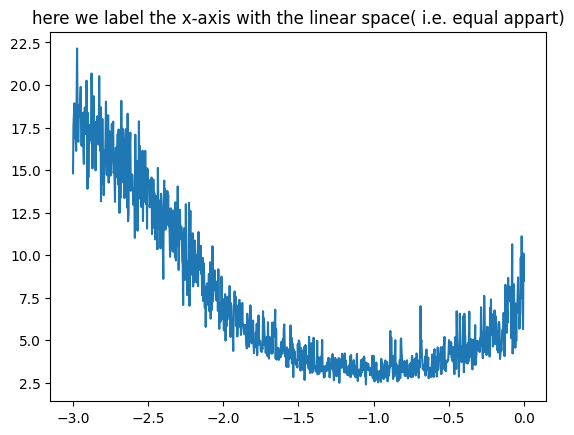

In [40]:
plt.plot(lr_exp_trans, lr_loss)
plt.title("here we label the x-axis with the linear space( i.e. equal appart)")

In [41]:
## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

iterations = 1000 
mini_batch_size = 32

## Construct Learning rates ##
lr_linear =  torch.linspace(0.001, 1, iterations)
lr_exp_trans = torch.linspace(-3, 0, iterations)
lr_exp = 10**lr_exp_trans # -3 because 10**-3 = 0.001 and 0 because 10**0 = 1

# keep track of the learning rates used; so we can plot
lr_idx = []
lr_loss = []


for i in reversed(range(iterations)):

   
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X[ix]] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    lr = lr_exp[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    #track the learning rates and the loss
    lr_idx.append(lr)
    lr_loss.append(loss.item())
print(f"Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: {loss.item():.3f}")


Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: 2.604


Text(0.5, 1.0, 'Reversed so starts large and goes small <-- time dir')

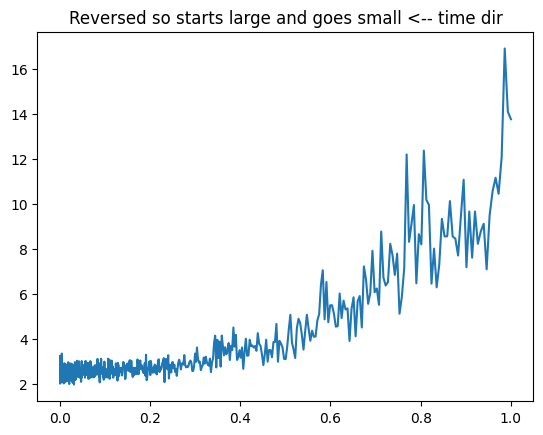

In [42]:
plt.plot(lr_idx, lr_loss)
plt.title("Reversed so starts large and goes small <-- time dir")

In [43]:
# RMSprop takes larger steps when the gradient is small and small steps when there has been a consitently large history of large gradients.
# here we are doing it on an iteration basis. the first iterations we assign a large learning rate, which gets smaller as the interations go on.

### Splitting data | Training, Validation and test

* The training is for training the model (optimising the parameters). 
* The Validation is used for optimising the hyper parameters of the model (number of neurons, rate of regularization, size of embedding, etc ...)
* The test set is used to validate the performance of the model

In [44]:
def create_dataset(names, context_len=3):
    """Function to create a dataset out of a list of names given to it

    Args:
        names (list)
        context_len (int, optional):Defaults to 3.

    Returns:
        tuple: X, Y
    """

    X, Y = [], []
    for name in names:
        #initalise context with "." characters (index 0)
        context = [0] * context_len
        
        for char in name + ".": # add end character to the name
            y = char_to_idx[char]
            X.append(context)
            Y.append(y)
        
            #shift the context (like a rolling window)
            context = context[1:] + [y]

    #store as tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [45]:
## Split simply by indexing
import random
random.shuffle(names)
train_split = int(0.8*len(names))
val_split = int(0.9*len(names))
X_train, Y_train = create_dataset(names[:train_split])
X_val, Y_val = create_dataset(names[train_split:val_split])
X_test, Y_test = create_dataset(names[val_split:])

In [46]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

torch.Size([182608, 3]) torch.Size([182608])
torch.Size([22784, 3]) torch.Size([22784])
torch.Size([22754, 3]) torch.Size([22754])


We can now train over the training data set and see the evalutaion on the validaton, for different configurations for the network.
We find that increaseing the Linear layer (with the tanh activation) doesnt improve the network that much and we believe this is because of the embedding dim being too small (currently two dim). before I increase the embedding dimension lets visualuse it to see if the network learns any cimalrities between characters

In [47]:
### Train network ###


## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

iterations = 50_000 
mini_batch_size = 32


for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    lr = 0.1 if i < 30_000 else 0.01 # At 30_000 iterations we shift the learing rate
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")

Current Loss: 13.943
Current Loss: 2.438
Current Loss: 2.681
Current Loss: 2.723
Current Loss: 2.132


In [48]:
## Run Forward pss on training set to get training loss

emb = C[X_train]
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_train)
print(f"training loss: {loss.item():.3f}")

training loss: 2.336


In [49]:
## Run forward pass on validation data to get validation loss
emb = C[X_val]
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_val)
print(f"Validation loss: {loss.item():.3f}")

Validation loss: 2.334


Notice they are the roughly the same. This suggested there is still room for imrpovement. But before that lets visualise the embedding matrix

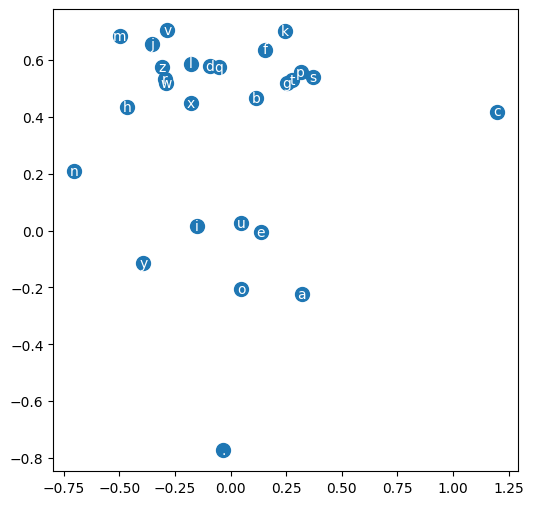

In [50]:
plt.figure(figsize=(6,6))
#plot the dims of the embedding matrix
plt.scatter(C[:, 0].data, C[:, 1].data, s=100)

#iterate through and on the dot place the letter
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), s=idx_to_char[i], ha="center", va="center", color="white")

Intrestingly, the vowels are clustered together! The model assigns similarlity to these, meaning theyre interchangeable in a sense!
There are the main cluster of letters in the center. 
there are q, ., y that are far away from the main cluster indicating that these are exceptional characters. Fasinating!!

Now lets play around with the hyper paramters to try and get a best model. here we are doiung this in a trail and error, unstructured way, but we'll learn about best practices soon. Lets just play for now!

Hyperparameters:
* Number of neurons in the linear layer
* batch_size
* number of dimensions in our embeddings
* learning rate
* context length

In [51]:
### Train network ###

ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 100_000


## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) 
b1 = torch.randn((ll_neurons)) 
w2 = torch.randn((ll_neurons, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 50_000:
        lr=0.1
    elif ((i>50_000) & (i<80_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")

Current Loss: 25.717
Current Loss: 2.575
Current Loss: 2.450
Current Loss: 2.269
Current Loss: 2.189
Current Loss: 2.339
Current Loss: 1.971
Current Loss: 2.135
Current Loss: 2.105
Current Loss: 2.178


In [52]:
## Run Forward pss on training set to get training loss

emb = C[X_train]
h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #<-- context_len=3
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_train)
print(f"training loss: {loss.item():.3f}")

training loss: 2.146


In [53]:
## Run forward pass on validation data to get validation loss
emb = C[X_val]
h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1)
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_val)
print(f"Validation loss: {loss.item():.3f}")

Validation loss: 2.173


In [54]:
@torch.no_grad()
def loss_on_split(split: str):
    x, y = {
        "train": (X_train, Y_train),
        "test": (X_test, Y_test),
        "val": (X_val, Y_val)
    }[split]
    
    
    #run forward pass and get loss
    emb = C[x]
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1)
    logits = h1 @ w2 + b2 
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.3f}")

### Sampling from the model

The model is trained. it has adjusted its weights to best minimise the loss. Now it is time to generate new samples. Think lets pass one data point through...

In [55]:
generated_chars = []
NUMBER_OF_NAMES = 10

for _ in range(NUMBER_OF_NAMES):
    #start with ...
    context = [0] * 3
    
    while True:
        #send it through the forward pass
        emb = C[context] #(1_example, context_len, emb_dim) = (1, 3, 10)
        h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(1, ll_neuron)
        logits = h1 @ w2 + b2 #(1, 27) <-- 27 is length of our vocab 

        #now we create the prob dist (note: this was previously done internallu in cross_entorpy - but we dont want t he loss calculation, we want the prob dist)
        prob_dist = F.softmax(logits, dim=1) #logits is a row vector, so calculate over the row (i.e. across dim 1 which the columns across the columns gives over the row)

        #now we sample from the dist (a multinomal will do that for us)
        idx = torch.multinomial(prob_dist, 1).item()
        generated_chars.append(idx_to_char[idx])

        if idx == 0:
            break

        context = context[1:] + [idx]

    print("".join(generated_chars))
    generated_chars=[]

hani.
ely.
zanakyrenatur.
karayha.
dupeus.
cry.
daliengutteelen.
mycelias.
chrigemy.
kayliah.


## Improving the Optimisation. Through weight initalisation.

Problems
1. Inital loss is very high, we waste time and resources fixing that, in the first few iterations
2. Saturated `tanh` where too many of our values fall within the flat area of the `tanh` (The pre-activations are too large). This causes the gradients to vanish. Which essentially turns off the tap for back prop, especially since tanh is one of the last function in the forward pass

In [56]:
### 4D example
# On the first forward pass - we would like our distribution of probabilities to be uniform.
# We have no reason to believe that it would be anything else Since each next character should be equally likely
# as we've done no learning. A uniform dist is our base case. 

#logits = torch.tensor([1.0, 1.0, 1.0, 1.0])


# but by randomly generating the initalisation, we most likely choose weights which lead to high probabilities in the wrong index.
# leading to our large loss.

# In this case the first few iterations are spend squashing the high initalisations down!

print("With Random Initalisation")
logits = torch.randn(4) * 10 #multiplied by ten to enphasize
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # second value is the truth label
print(probs, loss)


print("With Random Initalisation")
logits = torch.tensor([1.0, 1.0, 1.0, 1.0]) # uniform dist, all logits the same.
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # second value is the truth label
print(probs, loss)

# Ideally we want the logits to be all zero but we dont want to put all zeros into the intal weight values, we
# want there to be some entropy, so aim is to get them all close to zero

# the logits are h @ W2 + b2. h is the post activations of the previous layer (so cant do anything about those)
# but can do something about the initalisation of W2 and b2. squsih these closer to zero by multiply by 0.1 and 0.01!

With Random Initalisation
tensor([1.2395e-02, 8.0285e-03, 9.7958e-01, 1.3372e-12]) tensor(0.0206)
With Random Initalisation
tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)


In [57]:
### Train network - without the better initalisation for the logits ###

ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 100_000


## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) 
b1 = torch.randn((ll_neurons)) 
w2 = torch.randn((ll_neurons, 27))
b2 = torch.randn((27))
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 50_000:
        lr=0.1
    elif ((i>50_000) & (i<80_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")
    
    break

Current Loss: 29.849


In [58]:
logits[0].data

tensor([  2.7530, -15.1040,  -2.4514,  -2.9104,  -3.6035,  26.5108, -21.3550,
         -2.7742,  -5.0324,   8.6122, -10.7575, -10.3114, -11.5820,  -0.6948,
        -25.4730,  -6.3987, -14.7603,  14.4693,  -4.6045,   8.6681, -26.6831,
         26.9149,  19.9188,   9.4994, -19.0232,  25.0681,  -4.0062])

See how the inital logits from the very 1st forward pass are really high and very random. remember we want one very high and all others very low.

In [59]:
### Train network - WITH better initalisation for the logits ###

ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 100_000


## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) 
b1 = torch.randn((ll_neurons)) 
w2 = torch.randn((ll_neurons, 27)) * 0.01
b2 = torch.randn((27)) * 0.01
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 50_000:
        lr=0.1
    elif ((i>50_000) & (i<80_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")
    
    break

Current Loss: 3.299


In [60]:
logits[0].data

tensor([ 0.1354,  0.1679,  0.0822, -0.2242, -0.0205,  0.4188,  0.0490, -0.1277,
         0.1525,  0.2600,  0.1735, -0.0043, -0.0062, -0.2185, -0.1079, -0.0944,
        -0.0834, -0.1241, -0.0424,  0.1675,  0.1340, -0.0340, -0.0839,  0.1248,
        -0.1570, -0.1774,  0.2810])

This is much better place to start! the loss is already very low! None have got any preference over the other, we essentially have a uniform dist.

In [61]:
### Train network - WITH better initalisation for the logits ###

ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 80_000

loss_list = []
## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) 
b1 = torch.randn((ll_neurons)) 
w2 = torch.randn((ll_neurons, 27)) * 0.01
b2 = torch.randn((27)) * 0.01
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 30_000:
        lr=0.1
    elif ((i>30_000) & (i<60_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")
        loss_list.append(loss.item())

Current Loss: 3.294
Current Loss: 1.926
Current Loss: 2.046
Current Loss: 2.201
Current Loss: 2.149
Current Loss: 1.830
Current Loss: 2.149
Current Loss: 2.242


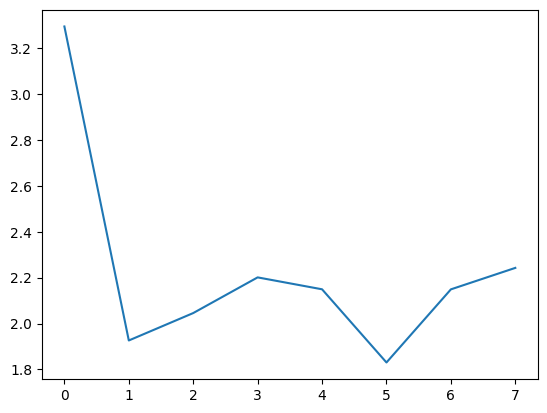

In [62]:
plt.plot(loss_list)

In [63]:
# Now rather than a hockey stick, we have a more gradual decline! becuase we removed the inital squishing.
# we also have more iterations avalible at the end to finer tune the loss (because we dont spend time squishing at start)

In [ ]:
loss_on_split("train") #2.14 before
loss_on_split("test") #2.17 before

train loss: 2.088
test loss: 2.155


#### Saturated Tanh

The logits are sorted, we have initalised the weight to be roughly uniform and close to zero, which cuts down the inital squashing of the weights.

Now the problem lies with the post-activations `h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1)`. if we take a look at the post and pre activations we see....

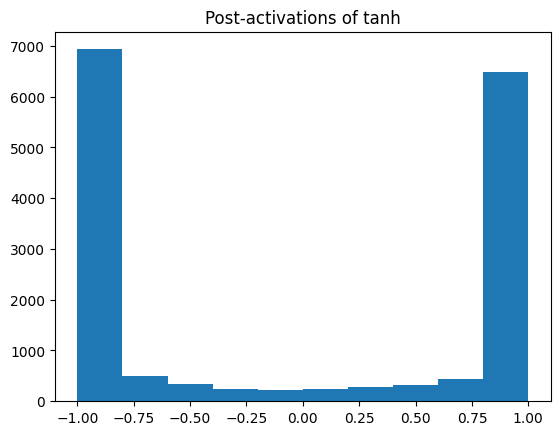

In [79]:
plt.hist(h1.view(-1).tolist())
plt.title("Post-activations of tanh")
plt.show()

We can see that most values fall in either +/- 1. Which means the pre-activations (what is being sent into the tanh function) are mostly large values which fall in the flat ends of the tanh.

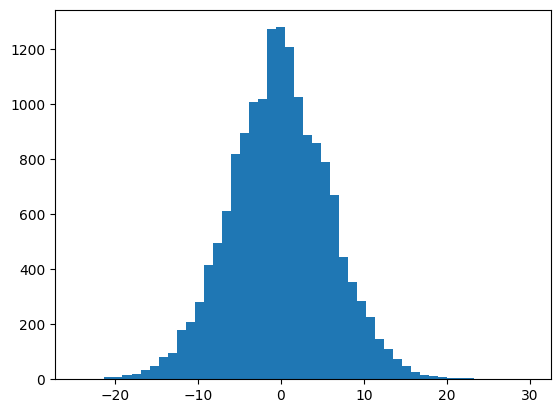

In [86]:
pre_act = emb.view(-1, 3*emb_dim) @ w1 + b1
plt.hist(pre_act.view(-1).data, bins=50)
plt.show()

Most of these pre-activations fall within the flat regions of tanh (i.e. above +/- 2). Now this causes a problem when we back propogate!. If we recall the dervative of the tanh is 1-tanh**2. so if the values of the post-activations are very close to +/-1 we find that the gradient is very very small and as we iterate they will vanish and the network will stop learning! Not Good!

We can see how many of the weights are zero-ing out, if all the weights zero-out (i.e. produce post-actrivations very close to +/- 1) then the whole neuron blacks out and is useless!

In [89]:
### Train network - WITH better initalisation for the logits ###

ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 80_000

loss_list = []
## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) 
b1 = torch.randn((ll_neurons)) 
w2 = torch.randn((ll_neurons, 27)) * 0.01
b2 = torch.randn((27)) * 0.01
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 30_000:
        lr=0.1
    elif ((i>30_000) & (i<60_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")
        loss_list.append(loss.item())
        
    break #after one interation!

Current Loss: 3.296


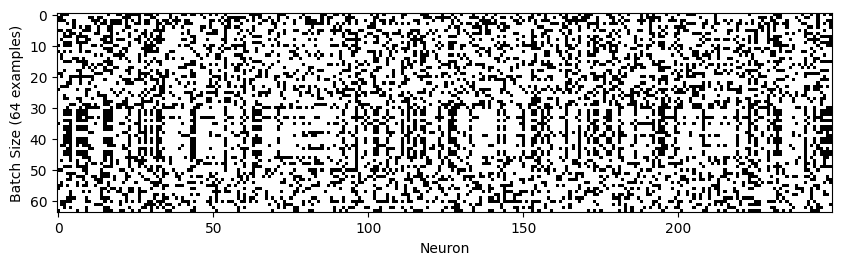

In [106]:
plt.figure(figsize=(10, 6))
plt.imshow(h1.abs() > 0.99, cmap="grey") #white if true, black if false
plt.xlabel("Neuron")
plt.ylabel("Batch Size (64 examples)")
plt.show()

if a whole column is whited out, then we have a blacked out neuron!

The problem lies in the pre-activations being too large, so lets make them smaller but initalising them closer to zero! if we multiply the initalisations by a decimal (0.2 say) (like we did for the initalisations of the logits), we should see more values falling in the diagnol of the tanh, which leads to sensible values fro the derivative of tanh in the backward pass

In [119]:
ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 80_000

loss_list = []
## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) * 0.2
b1 = torch.randn((ll_neurons)) * 0.1
w2 = torch.randn((ll_neurons, 27)) * 0.01
b2 = torch.randn((27)) * 0.01
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 30_000:
        lr=0.1
    elif ((i>30_000) & (i<60_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")
        loss_list.append(loss.item())
        
    break #after one interation!

Current Loss: 3.279


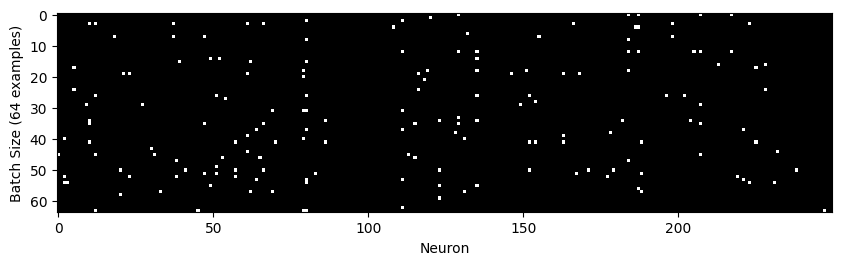

In [120]:
plt.figure(figsize=(10, 6))
plt.imshow(h1.abs() > 0.99, cmap="grey") #white if true, black if false
plt.xlabel("Neuron")
plt.ylabel("Batch Size (64 examples)")
plt.show()

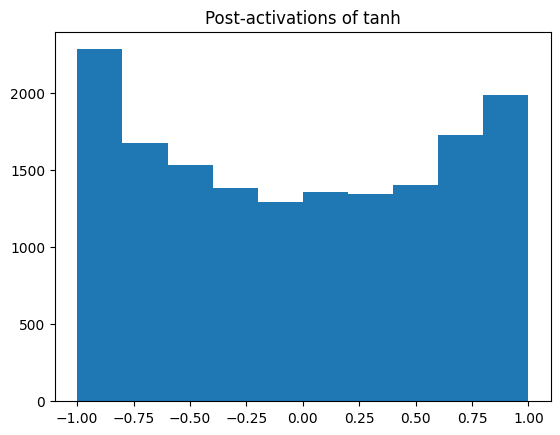

In [121]:
plt.hist(h1.view(-1).tolist())
plt.title("Post-activations of tanh")
plt.show()

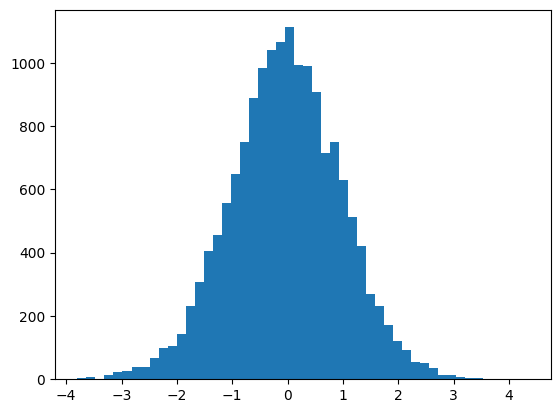

In [122]:
pre_act = emb.view(-1, 3*emb_dim) @ w1 + b1
plt.hist(pre_act.view(-1).data, bins=50)
plt.show()

pre-activations are much smaller and so more fall in the diagonal part of the tanh (+/-2). which leads to values within +/-1, which leads to sensible dervative values for tanh in the backwards pass!

NOTE: we dont want the weights to be too small, otherwise nothing will happen in the backwards pass, the gradients will just flow through. If pre-activations are too small then the derviative (1-tanh**2) will be approximately 1. Meaning the gradient will just pass straight through and will have no effect on the backwards pass. Also tanh(0) = 0, meaning the tanh adds nothing for very small values.

KEY: We want the pre-activations (just before they go into the tanh) to be roughly gaussian, because:
* If they are too small (very very close to zero) then the tanh becomes inactive tanh(0)=0 and in the backwards pass d/dx(tanh(x)) = 1-tanh(x)**2 = 1 and gradients just flow through and importantly there is no meaningful update to the gradient in the update step (just the other `∂L/∂w = ∂L/∂y * ∂y/∂z * ∂z/∂w` where `dy/dz`=1 as y=tanh(z))
* If they are way too large then the tanh is way to saturated (most values fall in the flats) and the gradient vanishes!

In [124]:
# lets run full optimisation with both initalisation improvements:

ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 80_000

loss_list = []
## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) * 0.2
b1 = torch.randn((ll_neurons)) * 0.1
w2 = torch.randn((ll_neurons, 27)) * 0.01
b2 = torch.randn((27)) * 0.01
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 30_000:
        lr=0.1
    elif ((i>30_000) & (i<60_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")
        loss_list.append(loss.item())

Current Loss: 3.316
Current Loss: 2.612
Current Loss: 2.271
Current Loss: 2.175
Current Loss: 1.950
Current Loss: 2.063
Current Loss: 2.280
Current Loss: 2.160


In [125]:
loss_on_split("train") #2.14 before then #2.09 with the logit init
loss_on_split("test") #2.17 before then #2.16

train loss: 2.053
test loss: 2.113


#### Kaiming int

When we multiply a normal gausian with mean=0 and std=1 with a decimal number we are squishing it from the left and right. We take a N(0, 1) * 0.2 and it becomes a N(0, 0.2). we are squishing in the std. the values are closer to zero, as the spread is less around the mean of zero.

But what is the appropriate value to set the std to for initalisation? Well there was a paper (Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - kaming He et al. (2015).) whihc descibes the appropriate scaling. Pytroch has a method for it `torch.nn.init.kaiming_normal_()`

In our case $$std=(5/3)/(fan_{in})^{0.5}$$ where the `fan_in= (context_len=3)*emb_dim` Its the 1st dimension of `w1`


The importance of these initalisations are not as important nower days due to modern investions such:
* Batch/layer normalisation
* residual connections
* better optimisers - Adam RMSprop

Mean the exact initalisations of the neural network is less important as these things make training more stable, but still is a nice thing to do.


### Adding Batch Normalisation

BN is placed arfter layers that contain multiplication!

In [1]:
import torch
import torch.nn.functional as F

In [2]:
names = open("names.txt", "r").read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(names)

32033

In [4]:
### Build the vocab ###

#find all characters in our dataset
vocab = sorted(list(set(''.join(names))))
vocab.insert(0, ".")

#create vocab mappings
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for idx, char in enumerate(vocab)}

In [5]:
context_len = 3
X, Y = [], []

for name in names:
    #initalise context with "." characters (index 0)
    context = [0] * context_len
    
    for char in name + ".": # add end character to the name
        y = char_to_idx[char]
        X.append(context)
        Y.append(y)

        #shift the context (like a rolling window)
        context = context[1:] + [y]

#store as tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
def create_dataset(names, context_len=3):
    """Function to create a dataset out of a list of names given to it

    Args:
        names (list)
        context_len (int, optional):Defaults to 3.

    Returns:
        tuple: X, Y
    """

    X, Y = [], []
    for name in names:
        #initalise context with "." characters (index 0)
        context = [0] * context_len
        
        for char in name + ".": # add end character to the name
            y = char_to_idx[char]
            X.append(context)
            Y.append(y)
        
            #shift the context (like a rolling window)
            context = context[1:] + [y]

    #store as tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [7]:
## Split simply by indexing
import random
random.shuffle(names)
train_split = int(0.8*len(names))
val_split = int(0.9*len(names))
X_train, Y_train = create_dataset(names[:train_split])
X_val, Y_val = create_dataset(names[train_split:val_split])
X_test, Y_test = create_dataset(names[val_split:])

In [8]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

torch.Size([182355, 3]) torch.Size([182355])
torch.Size([22760, 3]) torch.Size([22760])
torch.Size([23031, 3]) torch.Size([23031])


In [ ]:
# lets run full optimisation with both initalisation improvements:

ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 80_000

loss_list = []
## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) * (5/3) / (3*emb_dim)**0.5
b1 = torch.randn((ll_neurons)) * 0.1 #bias to be removed (see KEY POINT BELOW)
w2 = torch.randn((ll_neurons, 27)) * 0.01
b2 = torch.randn((27)) * 0.01

# shift and scale (learnable parameters)
bn_scale = torch.ones((1, ll_neurons))
bn_shift = torch.zeros((1, ll_neurons))

# Not learnable! iteratively updated in a running fashion during training
running_mean = torch.zeros((1, ll_neurons))
running_std = torch.ones((1, ll_neurons))

# ALL LEARNABLE PARAMETERS
parameters = [C, w1, b1, w2, b2, bn_scale, bn_shift]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   # random integers of the length mini_batch_size
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    pre_act = emb.view(-1, 3*emb_dim) @ w1 + b1 #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    
    ## BATCH NORM ## - standardize pre-activations then scale and shift (scale and shift are learnable parameters!)
    batch_mean = pre_act.mean(dim=0, keepdim=True)
    batch_std = pre_act.std(dim=0, keepdim=True)
    batch_norm = bn_scale * ((pre_act - batch_mean) / batch_std) + bn_shift
    
    # In inference we would like to predict on one example
    # Right now with batch_mean anf batch_std its not possible
    # So create a running mean and running std, to use in inference
    # These aren't learnt, they are estimated during train in a running fassion
    
    with torch.no_grad():
        running_mean = 0.999 * running_mean + 0.001 * batch_mean # what it was before plus a little bit from this batch
        running_std = 0.999 * running_std + 0.001 * batch_std
    
    
    h1 = torch.tanh(batch_norm) #(mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 30_000:
        lr=0.1
    elif ((i>30_000) & (i<60_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")
        loss_list.append(loss.item())

Current Loss: 3.308
Current Loss: 1.981
Current Loss: 2.057
Current Loss: 2.266
Current Loss: 2.053
Current Loss: 2.147
Current Loss: 2.204
Current Loss: 2.168


In [11]:
@torch.no_grad()
def loss_on_split(split: str):
    x, y = {
        "train": (X_train, Y_train),
        "test": (X_test, Y_test),
        "val": (X_val, Y_val)
    }[split]
    
    
    #run forward pass and get loss
    emb = C[x]
    pre_act = emb.view(-1, 3*emb_dim) @ w1 + b1
    # We use the running mean and std we calculated iteratively during training
    batch_norm = bn_scale * ((pre_act - running_mean) / (running_std**0.5)) + bn_shift
    h1 = torch.tanh(batch_norm)
    logits = h1 @ w2 + b2 
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.3f}")

In [12]:
loss_on_split("train")
loss_on_split("test")

train loss: 2.065
test loss: 2.104


An intresting property of batch normalisation is its regularization effect. Before BN we firstly sent one example in, calculated its activation and then its logit and sent through the becakwards pass. Then we started, for effeciency, processing batches of examples. But these batches were still independently processed. Now with BN, these batches and the examples in them become coupled (as we are taking the mean and std over the batch). Theyre no longer completely independent. What this means is that since we are sampling randomly for the batch, the resulting activations of a single example will change based on which examples come for a ride in the batch. i.e. if we have one example in a certain batch, it will give a certain activation value. if we take that same example but with a different batch, the activation will most likely be slightly different, becausde of the difference in the batches. As were takeing the mean and std over the batch, these will change for different batches!!!

its a bit like data augmentation. The example is gittered a bit for each different batch. which has a nice regularization effect, stopping the network over fitting

But we dont really like the coupling in batches! and researches have tried to look at different normalisation, that doesnt couple the batches. But Batch normulisation works well! (`GroupNormalisation`)

In [13]:
b1.grad # ALL ZEROS!!

tensor([ 9.3132e-10, -1.8626e-09, -4.6566e-10,  1.6298e-09,  9.3132e-10,
         1.3970e-09,  1.3970e-09,  2.3283e-09,  6.4028e-10,  1.3970e-09,
        -9.3132e-10,  1.4261e-09,  9.3132e-10, -1.3970e-09,  9.3132e-10,
         1.8626e-09, -1.7462e-10,  1.1642e-09,  3.7253e-09,  2.7940e-09,
         3.0268e-09,  2.3283e-10, -1.2806e-09,  2.5611e-09,  4.6566e-10,
         8.7311e-10, -6.9849e-10,  5.2969e-09, -9.3132e-10,  0.0000e+00,
        -2.3283e-09, -2.9104e-11, -2.3283e-10,  1.6298e-09, -1.3970e-09,
        -5.2387e-10,  9.3132e-10, -9.3132e-10,  9.3132e-10, -5.8208e-11,
        -5.8208e-10,  3.4925e-10, -5.8208e-10, -9.3132e-10, -1.8626e-09,
        -2.7940e-09, -1.1059e-09,  0.0000e+00,  0.0000e+00, -1.3970e-09,
         1.3970e-09,  4.6566e-10,  9.3132e-10,  1.1642e-09,  1.6298e-09,
         5.8208e-11, -2.3283e-10, -1.9209e-09, -1.3970e-09,  1.6298e-09,
         0.0000e+00,  7.5670e-10,  6.9849e-10, -1.8626e-09,  4.6566e-10,
         0.0000e+00,  4.6566e-10,  4.6566e-10,  3.2

KEY POINT: We dont need the bias in the pre activation layer because they are subtracted out in the batch norm! by subtracting the mean. We basically shift the dist by our bias and then subtract back by the mean (of the dist shifted by the bias) which will just shift it back to where it was before! So can remove the bias! The batch normalisation bias is now in charge of the biasing!